## Introduction:  Project 11
This notebook creates vacation brochures for 3 destinations across the Universe based on estimated flight distance & time from Earth, temperature, and atmosphere. We will have a list of 8 possible stars and planets you can visit while utilizing LLM API calls to generate 3 activites, cost, and a sentence brief description. Each brochure contains the destination name, description of destination that is stored as an attribute of the SpaceDestination class, specs (distance, travel time, etc), and a cheap and expensive version of activities as well as a cost estimate.


In [1]:
# pip installs and dependencies
%pip install openai anthropic python-dotenv matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


**Set up**

Download required libraries, initilize API key, and set up claude client for LLM API calls. 

In [2]:
from openai import OpenAI
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np

# Load environment variables from the .env file
load_dotenv()

# # Get the API key from the environment variable
# api_key = os.getenv("OPENAI_API_KEY")

# # Initialize the OpenAI client with the API key
# client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

#claude api
from anthropic import Anthropic

claude_api_key = os.getenv("ANTHROPIC_API_KEY")
client = Anthropic(api_key=claude_api_key) if claude_api_key else None

**Class Initialization for SpaceDestination and TourPackage**

---

SpaceDestination
- Name: string
- Distance: float (furtherest astronomical unit from Earth)
- Cost: $100 * (astronomical units)
- Description: short paragraph

Activity
- generated by LLM API call

TourPackage
- Destination: SpaceDestination object
- Tier: VIP or Budget
- Activity 1: Activity object
- Activitiy 2: Activity object

In [3]:
class SpaceDestination:
    def __init__(self, name, distance, description):
        self.name = name
        self.distance = distance
        self.cost = round(100 * float(distance), 2)
        self.description = description

    def __str__(self):
        return f"Travel to {self.name} Base Cost: ${self.cost}\tDistance:{self.distance} AU\n{self.description}\n\n"


class Activity:
    def __init__(self, name, cost, description):
        self.name = name
        self.cost = cost
        self.description = description
    def __str__(self):
        return f"{self.name}\n\nCost: ${self.cost}\n{self.description}"

class TourPackage:
    def __init__(self, dest, act1, act2, act3):
        self.dest = dest
        self.act1 = act1
        self.act2 = act2
        self.act3 = act3
        self.total_cost = round(float(dest.cost) + float(act1.cost) + float(act2.cost) + float(act3.cost), 2)
    
    def __str__(self):
        return (f"Activity 1: {self.act1}"
        f"\n\nActivity 2: {self.act2}"
        f"\n\nActivity 3: {self.act3}\n"
        "--------------------------------------------------------------------------------------------------"
        f"\n\nTotal Costs: ${self.total_cost}")

Our "database" of possible travel destinations. Not generated with LLM API due to cost constraints.

In [4]:
#List of 8 chooseable destinations
locations = []
locations.append(SpaceDestination("Mars", 2.5, "Desert-like rocky planet with a tenuous atmosphere."))
locations.append(SpaceDestination("Jupiter", 6.2, "Gas giant known for its colorful, swirling cloud bands and the Great Red Spot"))
locations.append(SpaceDestination("Uranus", 20.1, "Cold, blue-green, ice giant"))
locations.append(SpaceDestination("Pluto", 50, "Dwarf planet in the Kuiper Belt featuring varied terrain"))
locations.append(SpaceDestination("Mercury", 1.45, "Features a rocky surface, a large iron core, and extreme temperature variations"))
locations.append(SpaceDestination("Saturn", 10.07, "Gas giant with a prominent ring system made of ice and dust and massive gaseous atmosphere"))
locations.append(SpaceDestination("Ceres", 3.1, "Dwarf planet known for its high water ice content,"))
locations.append(SpaceDestination("Orcus", 48.91, "Dwarf planet in the Kuiper Belt rich in crystalline water ice"))

 **LLM integration**

---

Use LLM API call to:

1. Determine which 3 destinations to make a tour package for based on input from user goals.
    - Prompt asks for list of 3 destinations from already made list of 8
    - Our idea is for LLM to determine which fits best based on general knowledge of each location since this should be abstract
2. Use LLM API call to generate activities based on user goals.
    - Prompt asks for list of 3 activities for each destination based on small amount of provided info
    - Our idea is for LLM to determine which fits best based on general knowledge since we wanted a non realistic approach. -->


In [5]:
def llm_pick_destinations(user_goals, available_destinations):
    '''
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": f"From these destinations: {[d.name for d in available_destinations]}, pick 3 that best match these goals: '{user_goals}'. Reply with just the 3 names separated by commas."}],
            max_tokens=40,
        )
        return response.choices[0].message.content.strip()
    except:
        return "Mars, Jupiter, Saturn"
    ''' 

    # ''' 
    try: 
        response = client.messages.create( 
            model="claude-sonnet-4-20250514", 
            messages=[{"role": "user", 
                       "content": f"From these destinations: {[d.name for d in available_destinations]}, pick 3 that best match these goals: '{user_goals}'. Reply only with: [choice 1], [choice 2], [choice 3]."}], 
            max_tokens=40, 
        ) 
        return response.content[0].text.strip() 
    except: 
        # In case call fails, return these three. 
        return "Mars, Jupiter, Saturn" 
    # '''

# prompts the LLM to generate activities based on user goals
def llm_generate_activities(destination, user_goals, distance, cost):
    try:
        response = client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=300,  
            temperature=0.5,
            messages=[{
                "role": "user",
                "content": (
                    f"Generate exactly 3 creative unique space tourism activities for {destination}. "
                    f"User goals: {user_goals}. Budget: ${cost}. "
                    "You MUST GENERATE 3 ACTIVITIES. "
                    "Descriptions will be 1-3 complete sentences. "
                    "MUST use this EXACT format, separating each activity with '###':\n"
                    "Activity 1: [Name] | [Cost as a float] | [Description]\n###\n"
                    "Activity 2: [Name] | [Cost as a float] | [Description]\n###\n"
                    "Activity 3: [Name] | [Cost as a float] | [Description]"
                )
            }]
        )
        activities_text = response.content[0].text
        print(activities_text)
        return activities_text
    except Exception as e:
        print(f"Claude API error: {e}")
        # Default with costs calculated directly to avoid errors if API fails
        cost_base = cost 
        return (
            f"Activity 1: Surface Walk | {round(cost_base * 0.3, 2)} | Explore {destination} terrain for half a day.\n###\n"
            f"Activity 2: Photo Session | {round(cost_base * 0.4, 2)} | Capture {destination} views at the highest peak.\n###\n"
            f"Activity 3: Orbital Tour | {round(cost_base * 0.3, 2)} | See {destination} from a low orbit shuttle."
        )

In [6]:
# User input for goals/constraints.
print("Welcome to Space Tourism!")
print("What are your goals/constraints? (e.g., 'budget-friendly', 'luxury experience', 'adventure', 'relaxation')")
#print("Here is your package with some destinations and activities we think you'd enjoy!")
user_goals = input("Your goals: ").strip()

# LLM picks 3 destinations from your 8 options.
selected_names = llm_pick_destinations(user_goals, locations)
selected_destinations = [dest for dest in locations if dest.name in selected_names]

Welcome to Space Tourism!
What are your goals/constraints? (e.g., 'budget-friendly', 'luxury experience', 'adventure', 'relaxation')


In [7]:
'''
Functions to plot comparison graphs.
'''
def plot_travel_costs(selected_destinations, user_goals):
   # Simple plots for the 3 destinations LLM chose
  
   # Get data for selected destinations
   names = [dest.name for dest in selected_destinations]
   costs = [dest.cost for dest in selected_destinations]
   distances = [dest.distance for dest in selected_destinations]
  
   # Plot 1: bar chart showing travel cost
   plt.figure(figsize=(8, 5))
   plt.bar(names, costs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
   plt.title(f'Travel Costs')
   plt.ylabel('Cost ($)')
   plt.xlabel('Destinations')
   plt.show()
   #plt.savefig("Travel_cost_comparison.pdf")


def plot_total_costs(tour_pkgs):
   # Plot 2: scatter plot
   plt.figure(figsize=(8, 5))
   des = []
   costs = []
   for tour_pkg in enumerate(tour_pkgs):
       des.append(tour_pkg.dest)
       costs.append(float(tour_pkg.costs))
    
   plt.scatter(range(len(costs)), costs, s=100, c=['#FF6B6B', '#4ECDC4', '#45B7D1'])
   plt.title('Overall Cost')
   plt.xticks(range(len(des)), des, rotation=45)
   plt.ylabel('Cost ($)')
   plt.grid(True, alpha=0.3)
   plt.show()
   #plt.savefig("Distance_cost_comparison.pdf")


**LLM API Call**

In [8]:
packages = []
texts = []
# Generate brochures for selected destinations
for dest in selected_destinations:
    # LLM generates 3 activities based on user goals
    activities_text = llm_generate_activities(dest.name, user_goals, dest.distance, dest.cost)
    texts.append(activities_text)

Activity 1: Martian Crater Mini-Golf Adventure | 85.0 | Navigate a specially designed 18-hole mini-golf course built inside authentic Martian craters, where the low gravity creates exciting trick shots and floating ball trajectories. Each family member gets a glow-in-the-dark ball and putter designed for Mars' unique atmospheric conditions.

###

Activity 2: Red Planet Rock Climbing Expedition | 95.0 | Scale the towering rust-colored cliffs of Valles Marineris using lightweight climbing gear adapted for Mars' reduced gravity, allowing even beginners to reach impressive heights safely. The whole family will be tethered together as they explore ancient geological formations while enjoying panoramic views of the Martian landscape.

###

Activity 3: Underground Lava Tube Spelunking | 70.0 | Explore mysterious underground lava tubes formed by ancient volcanic activity, equipped with helmet lights and safety gear as you discover hidden Martian caves. Your family will search for unique minera

**make_brochure**
---
Purpose is to take in destination name and activities to make a tourpackage in a seperate file showcasing destination, activities. and costs.

In [9]:
def make_brochure(dest, activities_text):
    # Create file for each location chosen
    filename = f"{dest.name}_brochure.txt"
    with open(filename, 'w') as file:
        activities = []
        
        # Split the entire text block by the unique separator '###'
        activity_blocks = activities_text.split('###')
        
        # Iterate over the three expected blocks
        for block in activity_blocks:
            # Clean up block by splitting off the Activity number prefix and stripping whitespace
            if ':' in block and '|' in block:
                try:
                    # Isolate the content after the 'Activity X:' part (e.g., "Name | Cost | Description")
                    content = block.split(':', 1)[1].strip()
                    parts = content.split('|', 2) # Only split 2 times to ensure the description is the final, third part
                        
                    if len(parts) == 3:
                        name = parts[0].strip()
                        cost = float(parts[1].strip())
                        description = parts[2].strip()
                        activities.append(Activity(name, cost, description))
                except (ValueError, IndexError) as e:
                    print(f"Skipping activity due to parsing error in block: {e}")
                    continue

        # Ensure 3 activities were successfully parsed
        if len(activities) < 3:
            print(f"Error: Could only parse {len(activities)} activities for {dest.name}. Aborting package creation and writing a default file.")
            
            # Write a simple error message to the file instead of crashing, and is helpful for debugging
            file.write(f"\n=== {dest.name} Space Tour ===\n")
            file.write(f"ERROR: Failed to generate 3 activities in the correct format. {len(activities)} activities were found.\n")
            return
            
        # Create TourPackage object
        package = TourPackage(dest, activities[0], activities[1], activities[2])
        packages.append(package)
        
        # Print brochure with LLM chosen destinations and activities
        file.write(f"\n=== {dest.name} Space Tour ===\n"
        f"{str(dest)}"
        f"{str(package)}")

Call make_brochure to produce files showcasing all tour package info.

In [10]:
make_brochure(selected_destinations[0], texts[0])

make_brochure(selected_destinations[1],texts[1])

make_brochure(selected_destinations[2],texts[2])

**Plotting Comparison Figures**

---

Call plot_travel_costs to plot prices of traveling for trip.

Call plot_total_costs to plot total cost of tour packages.

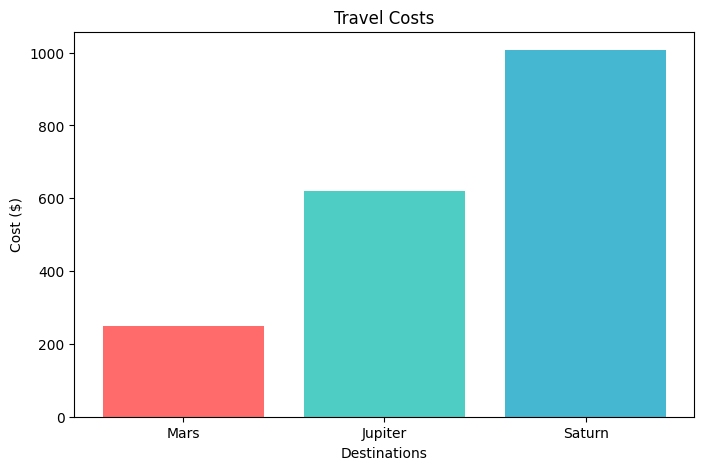

In [11]:
plot_travel_costs(selected_destinations, user_goals)

# plot_total_costs(packages)

### Individual Contribution Statements
---
Vivian Wang debugged code, added Markdown text sections, fixed coding errors.
Anshula Agolla worked on LLM integration and debugging.
Rory Conrad worked on MatPlot and graphs.
